### 先放个结果图

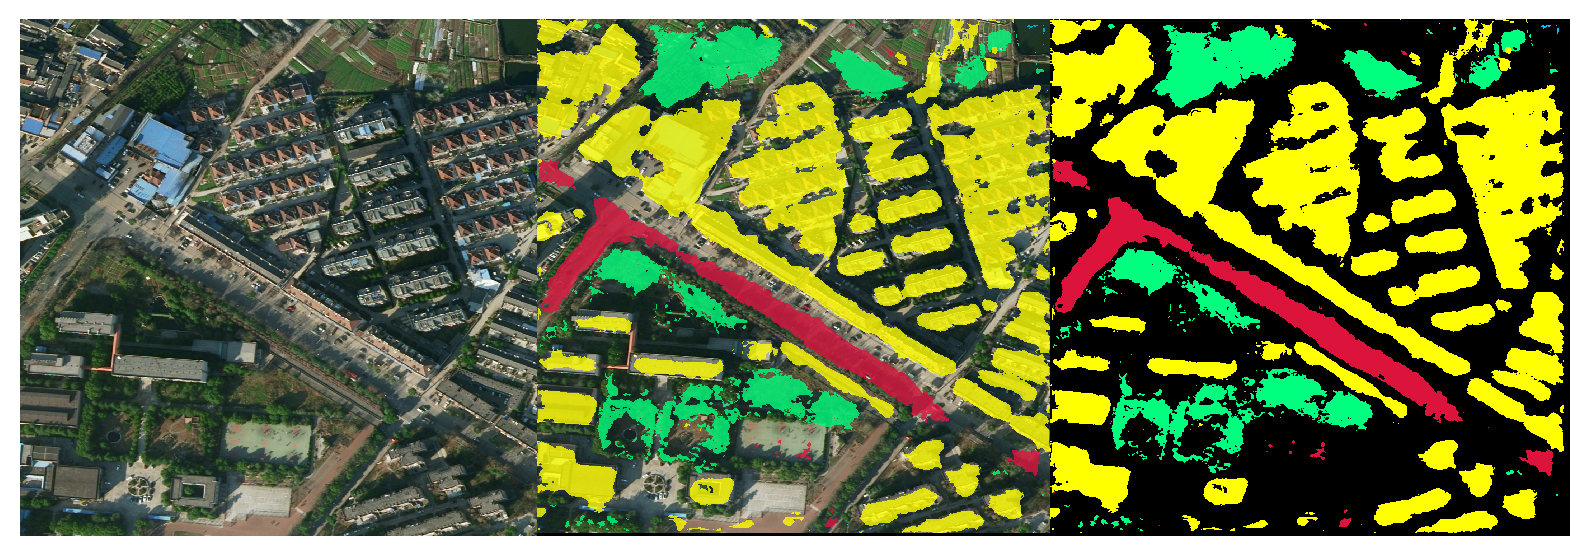

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize = (10 , 5),dpi=200)
img = Image.open(r"E:\dataset\BDCI2017-jiage-Semi\testing\testing3x-45-final.png")
img = np.array(img).astype('uint8')
plt.axis('off')
plt.imshow(img)

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import torch
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
from PIL.Image import NEAREST, BILINEAR, BICUBIC, LANCZOS, BOX, HAMMING
import os
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch as t
from PIL import Image
from torch.utils.data import DataLoader
from torch import optim
from torch.autograd import Variable 
import torch.nn as nn
from tqdm import tqdm
import torch as t
import logging as log


## 几个重要API讲解

In [2]:
# 双线性插值，用来进行2倍上采样，替代转置卷积操作
img = torch.Tensor([[[[10,20],[30,40]]]])
print(img.shape,'\n',img)

upsample = torch.nn.Upsample(scale_factor=2, mode='bilinear') # align_corners=None 默认为 False
img_upsample_2x = upsample(img)

print('upsample.shape = ',img_upsample_2x.shape,'\n',img_upsample_2x)

# 参考网址 https://www.cnblogs.com/wanghui-garcia/p/11399053.html
#          https://zhuanlan.zhihu.com/p/142985678

torch.Size([1, 1, 2, 2]) 
 tensor([[[[10., 20.],
          [30., 40.]]]])
upsample.shape =  torch.Size([1, 1, 4, 4]) 
 tensor([[[[10.0000, 12.5000, 17.5000, 20.0000],
          [15.0000, 17.5000, 22.5000, 25.0000],
          [25.0000, 27.5000, 32.5000, 35.0000],
          [30.0000, 32.5000, 37.5000, 40.0000]]]])


D:\Anaconda\envs\py37\lib\site-packages\torch\nn\functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [3]:
# 特征图的拼接，vs 特征图对应值相加

# 参考网址
#          https://www.cnblogs.com/JeasonIsCoding/p/10162356.html

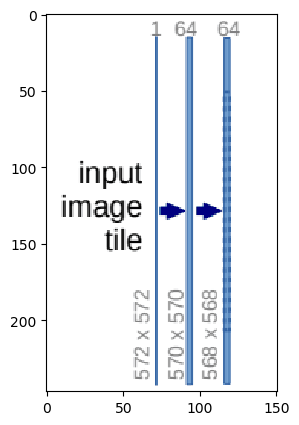

In [4]:
plt.figure(figsize=(8,5),dpi=100)
plt.imshow(Image.open('../pic/doubel_conv.png'))

In [3]:
#  双层卷积
#  完全还原当前图片
class double_conv(nn.Module):
    def __init__(self,in_channel,out_channels):
        super(double_conv,self).__init__()
        # h-2 , w-2, out_channels  ----> h-4, w-4, out_channels 
        self.conv_relu = nn.Sequential(
            nn.Conv2d(in_channel,out_channels,kernel_size = 3 ,stride = 1,padding = 0),nn.BatchNorm2d(out_channels),nn.ReLU(),
            nn.Conv2d(out_channels,out_channels,kernel_size = 3,stride = 1,padding  = 0),nn.BatchNorm2d(out_channels),nn.ReLU()
        )
    def forward(self,x):         # x = h, w, in_channels
        
        return self.conv_relu(x) # returns size = h-4, w-4, out_channels

In [4]:
import torch
img = torch.randn(1,3,572,572)
print(img.shape)
net = double_conv(3,64)
out = net(img)
print(out.shape)

torch.Size([1, 3, 572, 572])
torch.Size([1, 64, 568, 568])


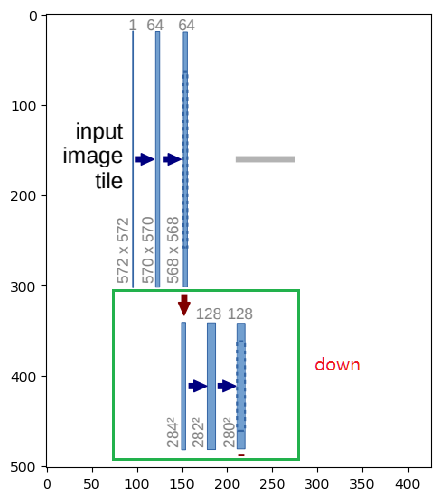

In [5]:
plt.figure(figsize=(10,6),dpi=100)
plt.imshow(Image.open('../pic/down.png'))

In [6]:
# 图中绿色的下采样块的结构

class Encoder(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Encoder,self).__init__()
        self.pool_and_conv = nn.Sequential(
            nn.MaxPool2d(kernel_size = 2,stride = 2), # 568*568*64 -->284*284*64
            double_conv(in_channels, out_channels)
        )
    def forward(self,x):
        return self.pool_and_conv(x)

print(out.shape)
encoder = Encoder(64, 128)
out = encoder(out)
print(out.shape)

torch.Size([1, 64, 568, 568])
torch.Size([1, 128, 280, 280])


### 解码层单元块

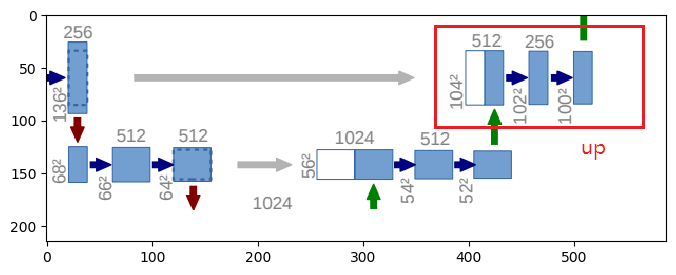

In [7]:
plt.figure(figsize=(8,5),dpi=100)
plt.imshow(Image.open('../pic/up.png'))

In [8]:
import torch.nn.functional as F

class Decoder(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Decoder,self).__init__()
        
        self.upsample = nn.Upsample(scale_factor=2,mode='bilinear') # 2倍
        
        self.double_conv = double_conv(in_channels, out_channels)  # (512 + 256) , (256)

    def forward(self,x1,x2): # x1 = 52,52,512  , x2 = 136,136,256 , 
        
        x1 = self.upsample(x1) # x1  = 104,104,512
        
        diffX, diffY = (x2.size()[2] - x1.size()[2]), (x2.size()[3] - x1.size()[3])
        padlen = (diffX//2,diffX-diffX//2,diffY//2,diffY-diffY//2) # left , right , top, bottom. 默认填充为0
        x1 = F.pad(x1, padlen)   #  136,136, 512          
        # 这里F.pad的这个函数参考本章末尾介绍
        # 这里torch.cat函数参考本章末尾介绍
        x1 = torch.cat([x1,x2],dim = 1) # 136,136,768   512+256 = 768
        
        return self.double_conv(x1) # returns 132,132, 256   height,width,channel

feature1 = torch.randn(1,512,52,52)
feature2 = torch.randn(1,256,136,136)
net = Decoder(512+256,256)
out = net(feature1,feature2)
print(out.size())

D:\Anaconda\envs\py37\lib\site-packages\torch\nn\functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([1, 256, 132, 132])


### 给特征图周围填充0或其他值，扩大特征图
104--->136

In [9]:
x2 = torch.randn(1,512,104,104)
x2 = F.pad(x2,(16,16,16,16))
print(x2.size())

torch.Size([1, 512, 136, 136])


### Unet特征融合之torch.cat
##### 将weight,height相同,channels不同的特征图融合在一起

In [10]:
x1 = torch.randn(1,256,136,136)
x2 = torch.cat([x2,x1],dim = 1)  # 这里的dim和torch.max中有些相似，相同点。
print(x2.size())

torch.Size([1, 768, 136, 136])


In [11]:
class UnetModel(nn.Module):
    '''
        example:
        ---------
            >>> unet = UnetModel(5)
            >>> out = unet(torch.randn(1,3,572,572))
            >>> out
            torch.Size([1, 5, 564, 564])
    
    '''
    def __init__(self,n_class):
        super(UnetModel,self).__init__()
        
        self.pre_pross = double_conv(3, 64)
        self.encoder1 = Encoder(64, 128)
        self.encoder2 = Encoder(128, 256)
        self.encoder3 = Encoder(256, 512)
        self.encoder4 = Encoder(512, 1024)
        
        self.decoder5 = Decoder(1024+512, 512)
        self.decoder4 = Decoder(512+256, 256)
        self.decoder3 = Decoder(256+128, 128)
        self.decoder2 = Decoder(128+64, 64)
        
        self.classifier = nn.Conv2d(64, n_class,kernel_size=1,stride=1)
        
    def forward(self, x):      # x = 572, 572, 3    # h,w,channels
        
        x1 = self.pre_pross(x) # x1 = 568,568, 64
        x2 = self.encoder1(x1) # x2 = 280,280,128
        x3 = self.encoder2(x2) # x3 = 136,136,256
        x4 = self.encoder3(x3) # x4 = 64 ,64 ,512
        x5 = self.encoder4(x4) # x5 = 28 ,28 ,1024
        
        x4 = self.decoder5(x5,x4) # x4 = 60 ,60 , 512
        x3 = self.decoder4(x4,x3) # x3 = 132,132, 256
        x2 = self.decoder3(x3,x2) # x2 = 276.276, 128
        x1 = self.decoder2(x2,x1) # x1 = 564,564, 64
        
        out = self.classifier(x1) # out = 564, 564, n_class
        
        return out

In [12]:
# test Unet Model
img = torch.randn(1,3,572,572)
unet = UnetModel(5)
out = unet(img)
print(out.shape)

torch.Size([1, 5, 564, 564])


### Unet Dataset

In [15]:
class UserDataset(Dataset):
    def __init__(self,train_path,label_path):
        super(UserDataset,self).__init__()
        self.imglist = [os.path.join(train_path, item) for item in os.listdir(train_path)]
        self.labellist = [os.path.join(label_path, item) for item in os.listdir(label_path)]
        self.transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        self.imglist.sort()
        self.labellist.sort()
        print(len(self.imglist))
        
    def __getitem__(self, index):
        img,label = Image.open(self.imglist[index]),Image.open(self.labellist[index])
        # 由于当前网络的输入是572,572,输出是 564,564。故标签的大小应该resize成564，564
        label = label.resize((564,564))
        return {'img': self.transforms(img),
                'label':t.from_numpy( np.array(label,dtype='uint8'))}
    
    def __len__(self):
        return len(self.imglist)

In [16]:
imgpath = r'E:/dataset/BDCI2017-jiage-Semi/training/unetdataset/train'
labelpath = r'E:/dataset/BDCI2017-jiage-Semi/training/unetdataset/train_labels'
userDataset = UserDataset(imgpath,labelpath)
sample = userDataset[0]
img = sample['img']
label = sample['label']
print('label.shape = ',label.shape,'img.shape = ',img.shape)
output_size = (564, 564)

7808
label.shape =  torch.Size([564, 564]) img.shape =  torch.Size([3, 572, 572])


In [17]:
cm2lb = np.array([[0,0,0,0],[0,255,127,200],[255,255,0,200],[0,191,255,200],[220,20,60,200]]).astype('uint8')

### Unet Train

In [25]:
import torch as t
import metrix.calMetric as mc # 这个度量网络性能的工具，下载请联系qq，252306098
# 安装这个metirx包，若有包名变化，访问右边地址。具体安装  pip install git+https://gitee.com/yuchende/python-utils.git@master

class UnetTrainUtil:
    def __init__(self, userDataset, batchSize, unet, modelSavePath, n_class, traindevice='cuda:0'):
        super(UnetTrainUtil, self).__init__()
        # 数据集迭代器加载
        self.dataLoader = DataLoader(userDataset, batch_size=batchSize, num_workers=0)
        # 如果有cuda用cuda计算
        self.device = torch.device(traindevice)  # cuda  "cuda:0" if torch.cuda.is_available() else "cpu"
        # 初始化网络
        self.unet = unet.to(self.device)  # .to(self.device) cuda
        # 优化器
        self.optimizer = optim.Adam(unet.parameters(), lr=1e-4)
        # 交叉熵计算器
        self.calLoss = nn.CrossEntropyLoss().to(self.device)  # .to(self.device) <====> .cuda()
        # 网络性能度量的计算工具，下载联系qq，252306098
        self.calmc = mc.CalMetricUtils(n_class)  # 有 n_class 个分类
        # 网络性能参数
        self.loss, self.acc, self.miou, self.pac = [0], [0], [0], [0]
        # 模型保存路径名
        self.modelsavepath = modelSavePath
        # 其他参数
        self.lendata = len(self.dataLoader)

    def trainUnet(self):
        for epoch in range(30):
            print('epoch = ' + str(epoch) + ',  loss = ' + str(self.loss))
            if epoch % 10 == 0 and epoch != 0:
                for group in self.optimizer.param_groups:
                    group['lr'] *= 0.5
            # 训练度量的指标
            train_loss, train_acc, train_miou, train_pixel_accuracy = 0, 0, 0, 0
            # 设置为训练过程。此时网络 的 参数能够进行参数学习
            self.unet.train()
            # 开始训练
            for i, sample in tqdm(enumerate(self.dataLoader)):
                #  Variable为tensor数据构建计算图，便于网络的运算 https://www.cnblogs.com/czz0508/p/10333359.html
                imgdata, imglabel = Variable(sample['img']).to(self.device), Variable(sample['label'].long()).to(self.device)  # .to(self.device) cuda

                self.optimizer.zero_grad()  # 梯度清0
                # 图片送入网络，并进行误差传播
                netOutput = self.unet(imgdata)  # 将训练图片 送入网络
                loss = self.calLoss(netOutput, imglabel)  # 计算损失, label 和 网络输出的预测的结果进行对比，计算loss
                loss.backward()  # 误差反向传播
                self.optimizer.step()  # 用优化器去更新权重参数
                # 准备计算指标的数据
                pre_label = netOutput.max(1)[1].data.cpu().numpy()
                pre_label = [i for i in pre_label]
                true_label = imglabel.data.cpu().numpy()
                true_label = [i for i in true_label]
                # 开始计算,并更新训练度量指标
                resultMetric = self.calmc(pre_label, true_label)
                train_loss += loss.item()
                train_acc += resultMetric['mean_class_accuracy']
                train_miou += resultMetric['miou']
                train_pixel_accuracy += resultMetric['pixel_accuracy']
                # 每200*batchSize张图片输出一下，各项指标
                if (i + 1) % 200 == 0:
                    train_str = 'i:{}、train_loss:{:.4f}、train_acc:{:.4f}、train_miou:{:.4f}、train_pixel_accuracy:{:.4f}、'.format(
                        i, (train_loss / i), (train_acc / i), (train_miou / i), (train_pixel_accuracy / i) )
                    print(train_str)

            if max(self.miou) <= (train_miou / self.lendata):
                print('self.miou.max = ',max(self.miou),end='------ save model')
                self.miou.append(train_miou / self.lendata)
                self.loss.append(train_loss / self.lendata)
                self.acc.append(train_acc / self.lendata)
                self.pac.append(train_pixel_accuracy / self.lendata)
                t.save(self.unet.state_dict(), self.modelsavepath)

        t.save(self.unet.state_dict(), self.modelsavepath)
        # 输出最终模型的 性能数据
        print('-------' * 15, end='end')
        train_str = 'train_loss:{:.4f}、train_acc:{:.4f}、train_miou:{:.4f}、train_pixel_accuracy:{:.4f}'.format(
            max(self.loss), max(self.acc), max(self.miou),max(self.pac))
        print(train_str)

## begin train

In [ ]:
'''
    The Current Word:
        Begin to train the Unet Model
    you need to prepare for those config:
        dataset of it's path include training image path and it's label path
        
'''
imgpath = r'E:/dataset/BDCI2017-jiage-Semi/training/unetdataset/train'
labelpath = r'E:/dataset/BDCI2017-jiage-Semi/training/unetdataset/train_labels'
modelSavePath = r'./unet.pth'
trainDevice = 'cuda:0'  # cuda:0  or  cpu
batchSize = 1
n_class = 5
'''
    time = total.loop * speed / 3600
    device  batchSize/total.loop  speed/each batch of it's train.time  
    cuda    1/7436                1.05s /2.06h or 123m
    cpu     4/1952                66.32s/35.7h 
    cpu     2/3904                30s   /32h
'''
userDataset = UserDataset(imgpath,labelpath)
unet = UnetModel(5)

unetTrainUtil = UnetTrainUtil(userDataset,batchSize,unet,modelSavePath, n_class,trainDevice )
unetTrainUtil.trainUnet()

## predict single picture

In [ ]:
predictImage = r"E:\dataset\BDCI2017-jiage-Semi\testing\testing3x-45.png"
resultSavePath = r"E:\dataset\BDCI2017-jiage-Semi\testing\testing3x-45-unet.png"
modelPath = r'C:\Users\yuchende\FCN\Pytorch-FCN\unet.pth'
#colormap = [[0,0,0,0],[0,255,127,200],[255,255,0,200],[0,191,255,200],[220,20,60,200]]
colormap = [[0,0,0],[0,255,127],[220,20,60],[255,255,0],[0,191,255]]
colorMap = np.array(colormap).astype('uint8')
ImageTransforms = transforms.Compose([transforms.ToTensor(),
                                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


print('*'*10,'predict start')
net = UnetModel(5)
net.load_state_dict(t.load(modelPath))
net.eval()

# begin predict
preImage = Image.open(predictImage)
preImage = ImageTransforms(preImage)
preImage = torch.unsqueeze(preImage,dim = 0)

out = net(preImage)
out = F.log_softmax(out,dim = 1)
out = out.max(1)[1].squeeze().cpu().data.numpy()
out = colorMap[out]
out = Image.fromarray(out)
out.save(resultSavePath)
out.show()

### 让预测图片成为原图的mask，覆盖其上

In [4]:
import cv2
import numpy as np

# 覆盖
img1 = cv2.imread(r"E:\dataset\BDCI2017-jiage-Semi\testing\testing3x-45.png", -1) # 原图
img2 = cv2.imread(r"E:\dataset\BDCI2017-jiage-Semi\testing\testing3x-45-unet-rgba.png", -1) # 透明图
h, w, c = img2.shape

img1 = cv2.resize(img1, (w, h), interpolation = cv2.INTER_CUBIC)
result = np.zeros((h, w, 3), np.uint8)

#fast
alpha = img2[:, :, 3] / 255.0
result[:, :, 0] = (1. - alpha) * img1[:, :, 0] + alpha * img2[:, :, 0]
result[:, :, 1] = (1. - alpha) * img1[:, :, 1] + alpha * img2[:, :, 1]
result[:, :, 2] = (1. - alpha) * img1[:, :, 2] + alpha * img2[:, :, 2]

path3 = r"E:\dataset\BDCI2017-jiage-Semi\testing\testing3x-45-unet-rgba-combine.png" # 覆盖的图

cv2.imwrite(path3 , result)

True

###  将3张图片连接到一起，原图，预测图覆盖的原图，预测图

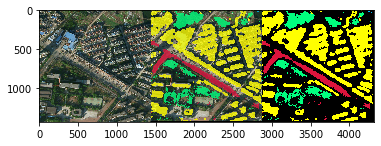

In [7]:
# cat
from PIL import Image
import matplotlib.pyplot as plt

predictImagePath = r"E:\dataset\BDCI2017-jiage-Semi\testing\testing3x-45.png"
predictResultSavePath = r"E:/dataset/BDCI2017-jiage-Semi/testing/testing3x-45-unet.png"

a,b,c = Image.open(predictImagePath),Image.open(r"E:\dataset\BDCI2017-jiage-Semi\testing\testing3x-45-unet-rgba-combine.png"),Image.open(predictResultSavePath)

d = Image.new('RGB',(a.size[0]*3,a.size[1]))
d.paste(a,(0,0))
d.paste(b,(a.size[0],0))
d.paste(c,(a.size[0]+b.size[0],0))

d.save(r"E:\dataset\BDCI2017-jiage-Semi\testing\testing3x-45-final.png")

plt.imshow(d)

## Unet输入和输出尺寸一致的网络结构

In [ ]:
import torch.nn as nn
import torch

class ConvBlock(nn.Module):
    """ implement conv+ReLU two times """
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        conv_relu = []
        conv_relu.append(nn.Conv2d(in_channels=in_channels, out_channels=middle_channels,
                                   kernel_size=3, padding=1, stride=1))
        conv_relu.append(nn.ReLU())
        conv_relu.append(nn.Conv2d(in_channels=middle_channels, out_channels=out_channels,
                                   kernel_size=3, padding=1, stride=1))
        conv_relu.append(nn.ReLU())
        self.conv_ReLU = nn.Sequential(*conv_relu)
    def forward(self, x):
        out = self.conv_ReLU(x)
        return out

class U_Net(nn.Module):
    def __init__(self):
        super().__init__()

        # 首先定义左半部分网络
        # left_conv_1 表示连续的两个（卷积+激活）
        # 随后进行最大池化
        self.left_conv_1 = ConvBlock(in_channels=3, middle_channels=64, out_channels=64)
        self.pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.left_conv_2 = ConvBlock(in_channels=64, middle_channels=128, out_channels=128)
        self.pool_2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.left_conv_3 = ConvBlock(in_channels=128, middle_channels=256, out_channels=256)
        self.pool_3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.left_conv_4 = ConvBlock(in_channels=256, middle_channels=512, out_channels=512)
        self.pool_4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.left_conv_5 = ConvBlock(in_channels=512, middle_channels=1024, out_channels=1024)

        # 定义右半部分网络
        self.deconv_1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.right_conv_1 = ConvBlock(in_channels=1024, middle_channels=512, out_channels=512)

        self.deconv_2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, padding=1, stride=2, output_padding=1)
        self.right_conv_2 = ConvBlock(in_channels=512, middle_channels=256, out_channels=256)

        self.deconv_3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, padding=1, stride=2 ,output_padding=1)
        self.right_conv_3 = ConvBlock(in_channels=256, middle_channels=128, out_channels=128)

        self.deconv_4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, output_padding=1, padding=1)
        self.right_conv_4 = ConvBlock(in_channels=128, middle_channels=64, out_channels=64)
        # 最后是1x1的卷积，用于将通道数化为3
        self.right_conv_5 = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=1, stride=1, padding=0)

    def forward(self, x):

        # 1：进行编码过程
        feature_1 = self.left_conv_1(x)
        feature_1_pool = self.pool_1(feature_1)

        feature_2 = self.left_conv_2(feature_1_pool)
        feature_2_pool = self.pool_2(feature_2)

        feature_3 = self.left_conv_3(feature_2_pool)
        feature_3_pool = self.pool_3(feature_3)

        feature_4 = self.left_conv_4(feature_3_pool)
        feature_4_pool = self.pool_4(feature_4)

        feature_5 = self.left_conv_5(feature_4_pool)

        # 2：进行解码过程
        de_feature_1 = self.deconv_1(feature_5)
        # 特征拼接
        temp = torch.cat((feature_4, de_feature_1), dim=1)
        de_feature_1_conv = self.right_conv_1(temp)

        de_feature_2 = self.deconv_2(de_feature_1_conv)
        temp = torch.cat((feature_3, de_feature_2), dim=1)
        de_feature_2_conv = self.right_conv_2(temp)

        de_feature_3 = self.deconv_3(de_feature_2_conv)

        temp = torch.cat((feature_2, de_feature_3), dim=1)
        de_feature_3_conv = self.right_conv_3(temp)

        de_feature_4 = self.deconv_4(de_feature_3_conv)
        temp = torch.cat((feature_1, de_feature_4), dim=1)
        de_feature_4_conv = self.right_conv_4(temp)

        out = self.right_conv_5(de_feature_4_conv)

        return out

x = torch.rand(size=(1, 3, 572, 572))
net = U_Net()
out = net(x)
print(out.size())
print("ok")